In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import r2_score


### MMM

In [2]:
final_df_execution = pd.read_csv("../data/Final_df_excution.csv")

In [3]:
df_final_execution = final_df_execution.drop(columns=[
    "UK L'Oreal Paris Haircare Offline Average Price (in pound)",
    "UK L'Oreal Paris Haircare Total Offline Sellout Value (in pound)",
    "UK L'Oreal Paris Haircare Total Offline Sellout Units", 
    "UK L'Oreal Paris Haircare Total Online Sellout Value (in pound)",
    "UK L'Oreal Paris Haircare Total Weigheted Promotion Distribution (%)", 
    #"UK L'Oreal Paris Haircare Online Average Price (in pound)"
]).rename(columns={'Unnamed: 0': 'Week_date'})
df_final_execution.head()


,Week_date,ap_consumer_facing | consumer_engagement | advocacy_media | influencer_management | influencer_management | engagements,ap_consumer_facing | consumer_engagement | paid_media | digital_tv | bvod | impressions,ap_consumer_facing | consumer_engagement | paid_media | online_multiformat_ads_transaction | amazon_retail | impressions,ap_consumer_facing | consumer_engagement | paid_media | online_multiformat_ads_transaction | tesco | impressions,ap_consumer_facing | consumer_engagement | paid_media | online_video_content_platforms | google_video | impressions,ap_consumer_facing | consumer_engagement | paid_media | online_video_content_platforms | youtube | impressions,ap_consumer_facing | consumer_engagement | paid_media | paid_search_awarenessconsideration | google | impressions,ap_consumer_facing | consumer_engagement | paid_media | paid_search_transaction | amazon | impressions,ap_consumer_facing | consumer_engagement | paid_media | paid_search_transaction | citrus | impressions,...,ap_consumer_facing | consumer_engagement | paid_media | social_media_awarenessconsideration | tik_tok | impressions,ap_consumer_facing | consumer_engagement | paid_media | social_media_transaction | meta | impressions,ap_consumer_facing | consumer_engagement | paid_media | social_media_transaction | meta_collab_ads | impressions,ap_consumer_facing | consumer_engagement | paid_media | social_media_transaction | tesco | impressions,ap_consumer_facing | consumer_engagement | paid_media | social_media_transaction | the_hut_group | impressions,ap_consumer_facing | consumer_engagement | paid_media | social_media_transaction | tik_tok | impressions,ap_consumer_facing | consumer_engagement | paid_media | traditional_tv | linear | grps,ap_consumer_facing | shopper_experience | shopper_experience | testers_and_merchandising | testers_and_merchandising | units,UK L'Oreal Paris Haircare Online Average Price (in pound),UK L'Oreal Paris Haircare Total Online Sellout Units
0,2022-01-03,537.216943,0.00,193246.3,0.0,0.0,0.0,4067.7,1468912.9,0.0,...,0.0,0.0,1507673.7,0.0,0.0,0.0,0.00,330.571429,3.242071,111888.4
1,2022-01-10,0.000000,0.00,343567.9,0.0,0.0,0.0,3716.7,2474498.0,0.0,...,0.0,0.0,1662391.9,0.0,0.0,0.0,0.00,261.151429,2.978819,129334.4
2,2022-01-17,0.000000,0.00,448357.0,0.0,0.0,0.0,4264.0,2691219.7,0.0,...,0.0,0.0,1781321.1,0.0,0.0,0.0,0.00,340.488571,3.014039,119282.8
3,2022-01-24,142432.121596,815102.08,626307.5,0.0,0.0,0.0,4633.2,1940061.5,0.0,...,0.0,0.0,1750936.2,0.0,0.0,0.0,58.63,421.908314,3.077403,116281.1
4,2022-01-31,95869.369418,679251.82,619993.4,0.0,0.0,0.0,2134.6,2349322.3,0.0,...,0.0,0.0,1959865.7,0.0,0.0,0.0,100.49,513.410486,3.306272,116873.9


In [4]:
df_final_execution.columns

Index(['Week_date',
       'ap_consumer_facing | consumer_engagement | advocacy_media | influencer_management | influencer_management | engagements',
       'ap_consumer_facing | consumer_engagement | paid_media | digital_tv | bvod | impressions',
       'ap_consumer_facing | consumer_engagement | paid_media | online_multiformat_ads_transaction | amazon_retail | impressions',
       'ap_consumer_facing | consumer_engagement | paid_media | online_multiformat_ads_transaction | tesco | impressions',
       'ap_consumer_facing | consumer_engagement | paid_media | online_video_content_platforms | google_video | impressions',
       'ap_consumer_facing | consumer_engagement | paid_media | online_video_content_platforms | youtube | impressions',
       'ap_consumer_facing | consumer_engagement | paid_media | paid_search_awarenessconsideration | google | impressions',
       'ap_consumer_facing | consumer_engagement | paid_media | paid_search_transaction | amazon | impressions',
       'ap_con

In [5]:
df_final_execution['Week_date'] = pd.to_datetime(df_final_execution['Week_date'])
df_final_execution.set_index('Week_date', inplace=True)


# Lags

In [6]:
# Choix de ma part, ouvert à discussion
ad_channels_for_lags = [
    'ap_consumer_facing | consumer_engagement | paid_media | digital_tv | bvod | impressions',  # TV
    'ap_consumer_facing | consumer_engagement | paid_media | online_video_content_platforms | youtube | impressions',  # YouTube
    'ap_consumer_facing | consumer_engagement | paid_media | online_multiformat_ads_transaction | amazon_retail | impressions',  # Amazon
    'ap_consumer_facing | consumer_engagement | paid_media | paid_search_awarenessconsideration | google | impressions',  # Google
    'ap_consumer_facing | consumer_engagement | paid_media | social_media_transaction | meta | impressions',  # Meta (Social Media)
    'ap_consumer_facing | consumer_engagement | paid_media | social_media_transaction | tik_tok | impressions',  # TikTok
    'ap_consumer_facing | consumer_engagement | advocacy_media | influencer_management | influencer_management | engagements',  # Influencer Marketing
]

for channel in ad_channels_for_lags:
    for lag in range(1, 5):  # Creating 4 lags
        df_final_execution[f'{channel}_lag_{lag}'] = df_final_execution[channel].shift(lag)

df_final_execution.fillna(0, inplace=True) # Fillage à la dur

### Adstocks

In [7]:
alpha = 0.5  # Sur conseil du chat
for channel in ad_channels_for_lags:
    df_final_execution[f'{channel}_adstock'] = 0
    for t in range(1, len(df_final_execution)):
        df_final_execution.loc[df_final_execution.index[t], f'{channel}_adstock'] = df_final_execution.loc[df_final_execution.index[t], channel] + alpha * df_final_execution.loc[df_final_execution.index[t-1], f'{channel}_adstock']

/var/folders/3l/_hdyb1rx2yq_frxtjyy_t_7m0000gn/T/ipykernel_18045/1502108915.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '815102.08' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_final_execution.loc[df_final_execution.index[t], f'{channel}_adstock'] = df_final_execution.loc[df_final_execution.index[t], channel] + alpha * df_final_execution.loc[df_final_execution.index[t-1], f'{channel}_adstock']
/var/folders/3l/_hdyb1rx2yq_frxtjyy_t_7m0000gn/T/ipykernel_18045/1502108915.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1133346.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_final_execution.loc[df_final_execution.index[t], f'{channel}_adstock'] = df_final_execution.loc[df_final_execution.index[t], channel] + alpha * df_final

### Seasonality

In [8]:
def add_seasonality_features(df, n_periods=2):
    """
    Add seasonal features using Fourier terms
    n_periods: number of seasonal periods to model (higher = more complex seasonality)
    """
    # Cf weekly data
    n_weeks = 52
    time_idx = np.arange(len(df))
    
    seasonal_features = pd.DataFrame(index=df.index)
    
    # Add sine and cosine terms sur conseil du chat
    for period in range(1, n_periods + 1):
        seasonal_features[f'sin_{period}'] = np.sin(2 * np.pi * period * time_idx / n_weeks)
        seasonal_features[f'cos_{period}'] = np.cos(2 * np.pi * period * time_idx / n_weeks)
    
    return seasonal_features

# Merge 
seasonal_features = add_seasonality_features(df_final_execution, n_periods=2)
df_final_execution = pd.concat([df_final_execution, seasonal_features], axis=1)

### Model

In [9]:
y = df_final_execution['UK L\'Oreal Paris Haircare Total Online Sellout Units']
X = df_final_execution.drop(columns=['UK L\'Oreal Paris Haircare Total Online Sellout Units'])

# Intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

# Evaluate model
y_pred = model.predict(X)
rmse = mean_squared_error(y, y_pred)
print(f"RMSE: {rmse}")

                                             OLS Regression Results                                             
Dep. Variable:     UK L'Oreal Paris Haircare Total Online Sellout Units   R-squared:                       0.884
Model:                                                              OLS   Adj. R-squared:                  0.722
Method:                                                   Least Squares   F-statistic:                     5.453
Date:                                                  Tue, 04 Feb 2025   Prob (F-statistic):           2.73e-08
Time:                                                          17:58:37   Log-Likelihood:                -1066.0
No. Observations:                                                   104   AIC:                             2254.
Df Residuals:                                                        43   BIC:                             2415.
Df Model:                                                            60                         

# PLOT

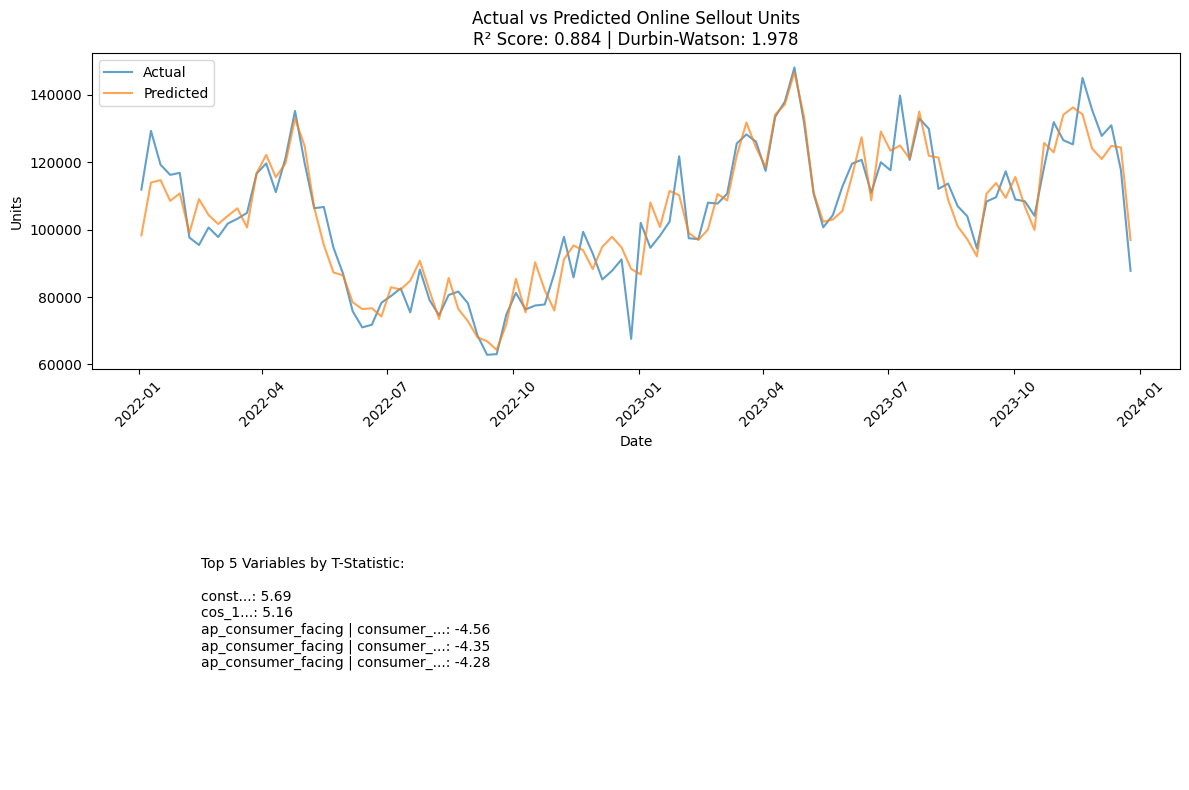


Detailed Model Statistics:
--------------------------------------------------
R² Score: 0.884
Durbin-Watson Statistic: 1.978

T-Statistics for all variables:
--------------------------------------------------
                                                                                             Variable  \
const                                                                                           const   
cos_1                                                                                           cos_1   
ap_consumer_facing | consumer_engagement | paid...  ap_consumer_facing | consumer_engagement | pai...   
ap_consumer_facing | consumer_engagement | paid...  ap_consumer_facing | consumer_engagement | pai...   
ap_consumer_facing | consumer_engagement | paid...  ap_consumer_facing | consumer_engagement | pai...   
...                                                                                               ...   
ap_consumer_facing | consumer_engagement | paid...  ap_

In [10]:
from sklearn.metrics import r2_score
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Calculate metrics
r2 = r2_score(y, y_pred)
dw_stat = durbin_watson(model.resid)
t_stats = model.tvalues

# Plot
plt.figure(figsize=(12, 8))

# Main plot
plt.subplot(2, 1, 1)  # Create subplot for the main time series
plt.plot(df_final_execution.index, y, label='Actual', alpha=0.7)
plt.plot(df_final_execution.index, y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Online Sellout Units\n' + 
          f'R² Score: {r2:.3f} | Durbin-Watson: {dw_stat:.3f}')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.xticks(rotation=45)

# Add text box with top 5 significant variables
top_5_vars = pd.DataFrame({
    'Variable': X.columns,
    'T-Stat': t_stats
}).sort_values('T-Stat', key=abs, ascending=False).head()

text_str = 'Top 5 Variables by T-Statistic:\n\n'
for idx, row in top_5_vars.iterrows():
    text_str += f"{row['Variable'][:30]}...: {row['T-Stat']:.2f}\n"

plt.subplot(2, 1, 2)  # Create subplot for the statistics
plt.axis('off')
plt.text(0.1, 0.5, text_str, fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

# Print additional model diagnostics
print("\nDetailed Model Statistics:")
print("-" * 50)
print(f"R² Score: {r2:.3f}")
print(f"Durbin-Watson Statistic: {dw_stat:.3f}")
print("\nT-Statistics for all variables:")
print("-" * 50)
t_stats_df = pd.DataFrame({
    'Variable': X.columns,
    'T-Statistic': t_stats,
    'P-Value': model.pvalues
}).sort_values('T-Statistic', key=abs, ascending=False)
print(t_stats_df)